In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

matplotlib.rcParams["font.size"] = 25
matplotlib.rcParams['figure.figsize'] = [10,10]

In [2]:
train_init = pd.read_csv('train.csv')
test_init = pd.read_csv('test.csv')

In [3]:
train_init.head() #show the first elements of the training sample

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
train_init.describe() #Show some relevant parameters of feature distributions

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [5]:
mask = train_init.isna().any()
col_nan = train_init.columns[mask] #fhese features contain NaN
print(col_nan)

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [6]:
train_init[col_nan].isna().sum() #count the missing value for each feature

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

# 1. Dataset inspection

First, let us observe the distribution of the target feature, `SalePrice`:

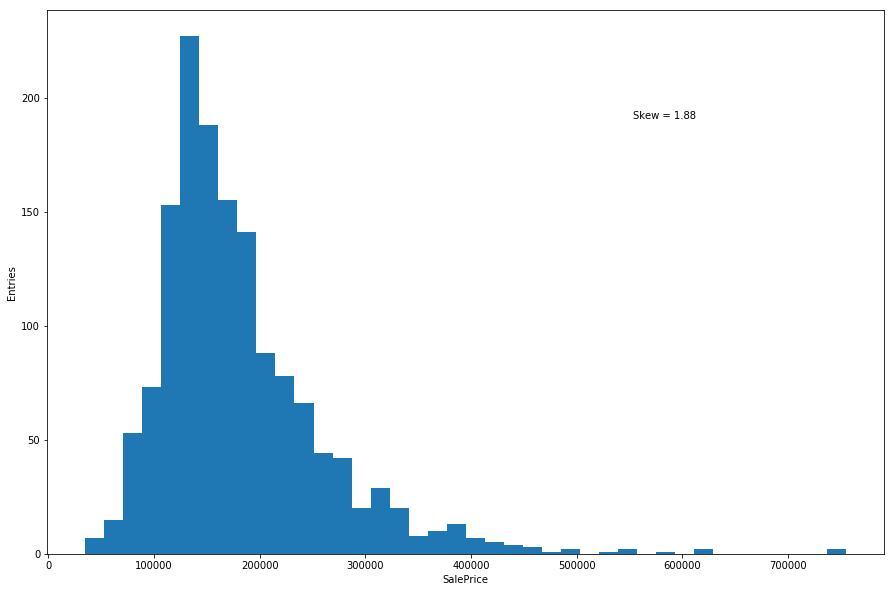

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))

SalePriceSkewness = train_init['SalePrice'].skew()
plt.hist(train_init['SalePrice'], bins=40)
plt.text(0.7, 0.8, 'Skew = {:.2f}'.format(SalePriceSkewness), transform=ax.transAxes)
plt.xlabel('SalePrice')
plt.ylabel('Entries')

plt.show()

The distribution is smooth but asymmetric, peaking at ~150

Let us investigate which variables might be the most correlated with the sale price. We start with a heatmap:

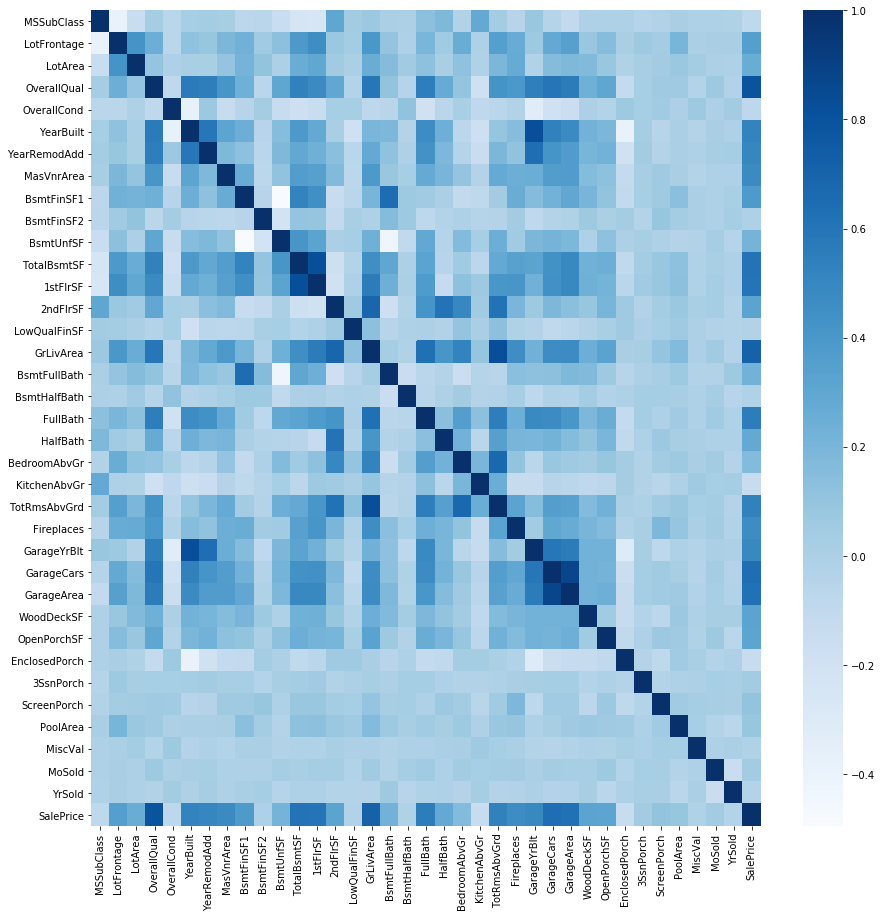

In [8]:
matplotlib.rcParams["font.size"] = 10
plt.figure(figsize= (15 , 15))
sns.heatmap(train_init.drop("Id", axis = 1).corr(),cmap="Blues")

From a first inspection, it seems that `OverallQual`, `GrLivArea`, and `GarageCars` are powerful features. Let us start considering numerical features, and then categorical features

## 1.1 Numerical Features 

In [9]:
#select numerical features
numerical_features = train_init.select_dtypes(include=[np.number]).drop(['SalePrice',  'Id'], axis=1).columns
print('Numerical features (%d):\n %s' %(len(numerical_features), numerical_features))

Numerical features (36):
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


### 1.1.1 Handling missing values

Some features contain NaN values (see above). Let us estimate the NaN values using the `IterativeImputer` provided by `sklearn`

In [10]:
imputer = IterativeImputer()

imputed_train = pd.DataFrame(
    imputer.fit_transform(train_init[numerical_features]),
    columns=list(train_init[numerical_features])
)

imputed_test  = pd.DataFrame(
    imputer.transform(test_init[numerical_features]),
    columns=list(test_init[numerical_features])
)

for var in numerical_features:
    train_init[var] = imputed_train[var]
    test_init[var]  = imputed_test[var]

### 1.1.2 Data Visualization & Correlation Estimation

In [11]:
def make_scatter(varname1, varname2, ax):
    ax.scatter(train_init[varname1], train_init[varname2])
    ax.set_xlabel(varname1)
    ax.set_ylabel(varname2)

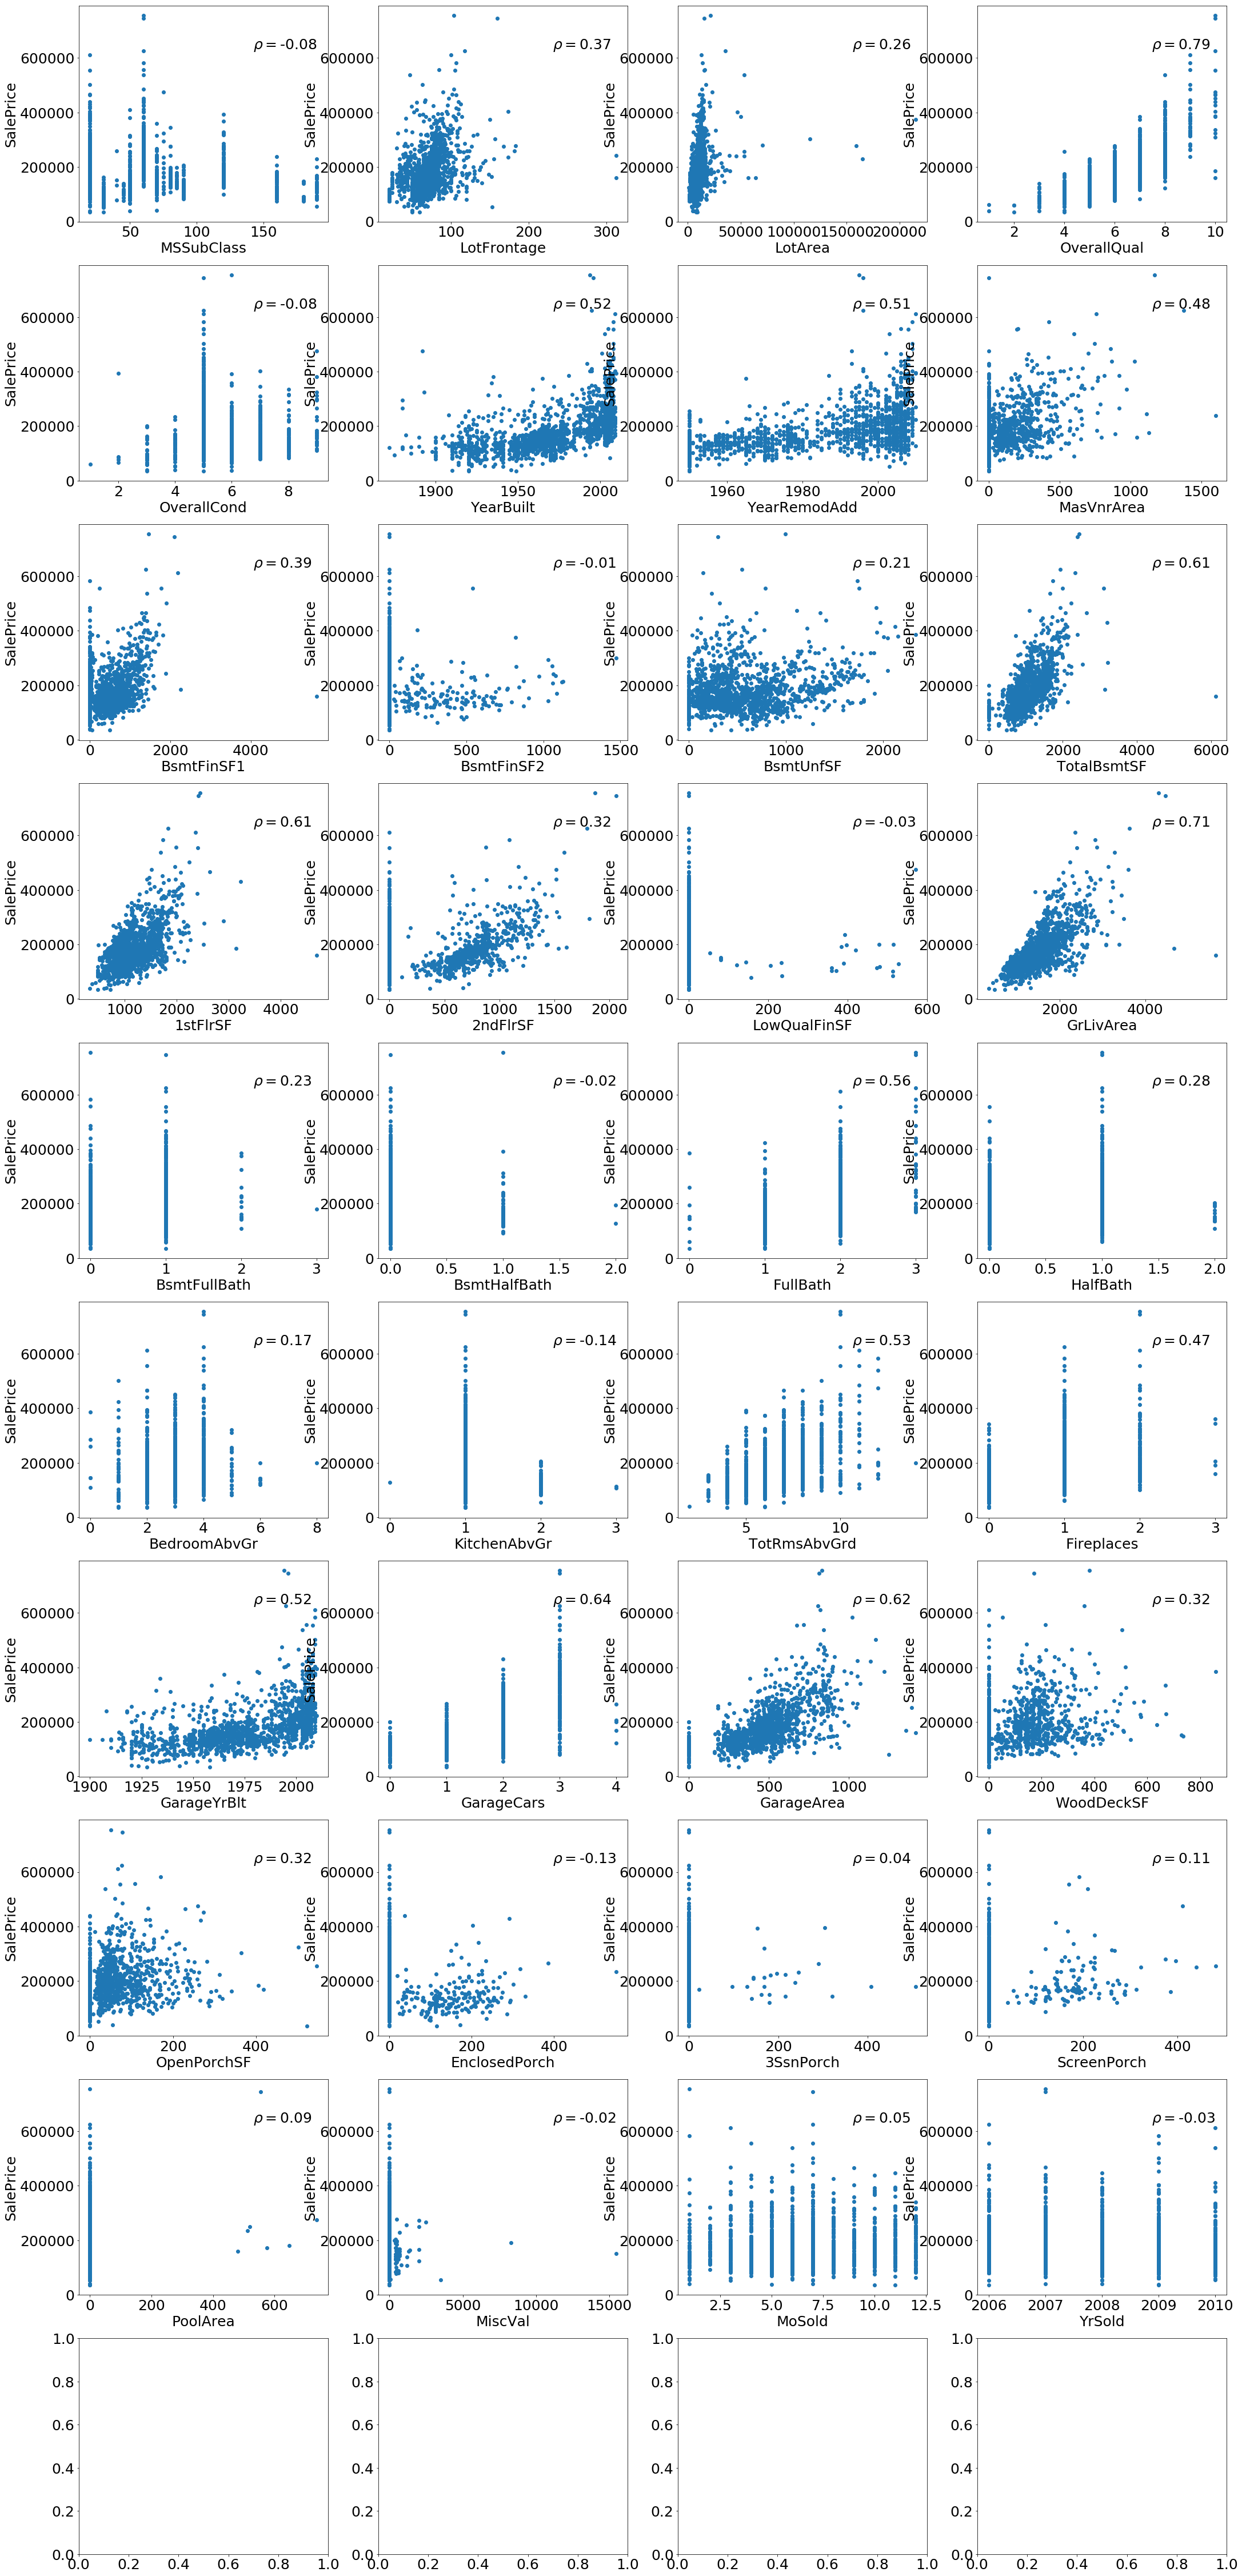

In [12]:
matplotlib.rcParams["font.size"] = 25

rho = []

fig, axs = plt.subplots(nrows=9, ncols=4, figsize=(36, 82))

for ivar, var in enumerate(numerical_features):
    row = int(ivar/4)
    col = ivar%4
    make_scatter(var, 'SalePrice', axs[row, col])
    rho.append(pearsonr(train_init[var], train_init['SalePrice'])[0])
    plt.text(0.7, 0.8, r'$\rho=${:.2f}'.format(rho[-1]), transform=axs[row, col].transAxes)

plt.show()

Some features show a high degree of correlation with the sale price ($\rho>60\%$). Neverthless, some might be cross-correlated, hence not providing much more information than a single feature. Below is the list of real-value features with the corresponding correlation

In [13]:
num_feat = pd.DataFrame({
    'variable': numerical_features,
    'rho': rho
})

num_feat.sort_values(by=['rho'], ascending=False)

rho       variable
3   0.790982    OverallQual
15  0.708624      GrLivArea
25  0.640409     GarageCars
26  0.623431     GarageArea
11  0.613581    TotalBsmtSF
12  0.605852       1stFlrSF
18  0.560664       FullBath
22  0.533723   TotRmsAbvGrd
5   0.522897      YearBuilt
24  0.518839    GarageYrBlt
6   0.507101   YearRemodAdd
7   0.477836     MasVnrArea
23  0.466929     Fireplaces
8   0.386420     BsmtFinSF1
1   0.368333    LotFrontage
27  0.324413     WoodDeckSF
13  0.319334       2ndFlrSF
28  0.315856    OpenPorchSF
19  0.284108       HalfBath
2   0.263843        LotArea
16  0.227122   BsmtFullBath
10  0.214479      BsmtUnfSF
20  0.168213   BedroomAbvGr
31  0.111447    ScreenPorch
32  0.092404       PoolArea
34  0.046432         MoSold
30  0.044584      3SsnPorch
9  -0.011378     BsmtFinSF2
17 -0.016844   BsmtHalfBath
33 -0.021190        MiscVal
14 -0.025606   LowQualFinSF
35 -0.028923         YrSold
4  -0.077856    OverallCond
0  -0.084284     MSSubClass
29 -0.128578  EnclosedPorch
21 -0.135907   KitchenAbvGr

Now can check the cross-correlations among the 6 top variables ($\rho>60\%$)

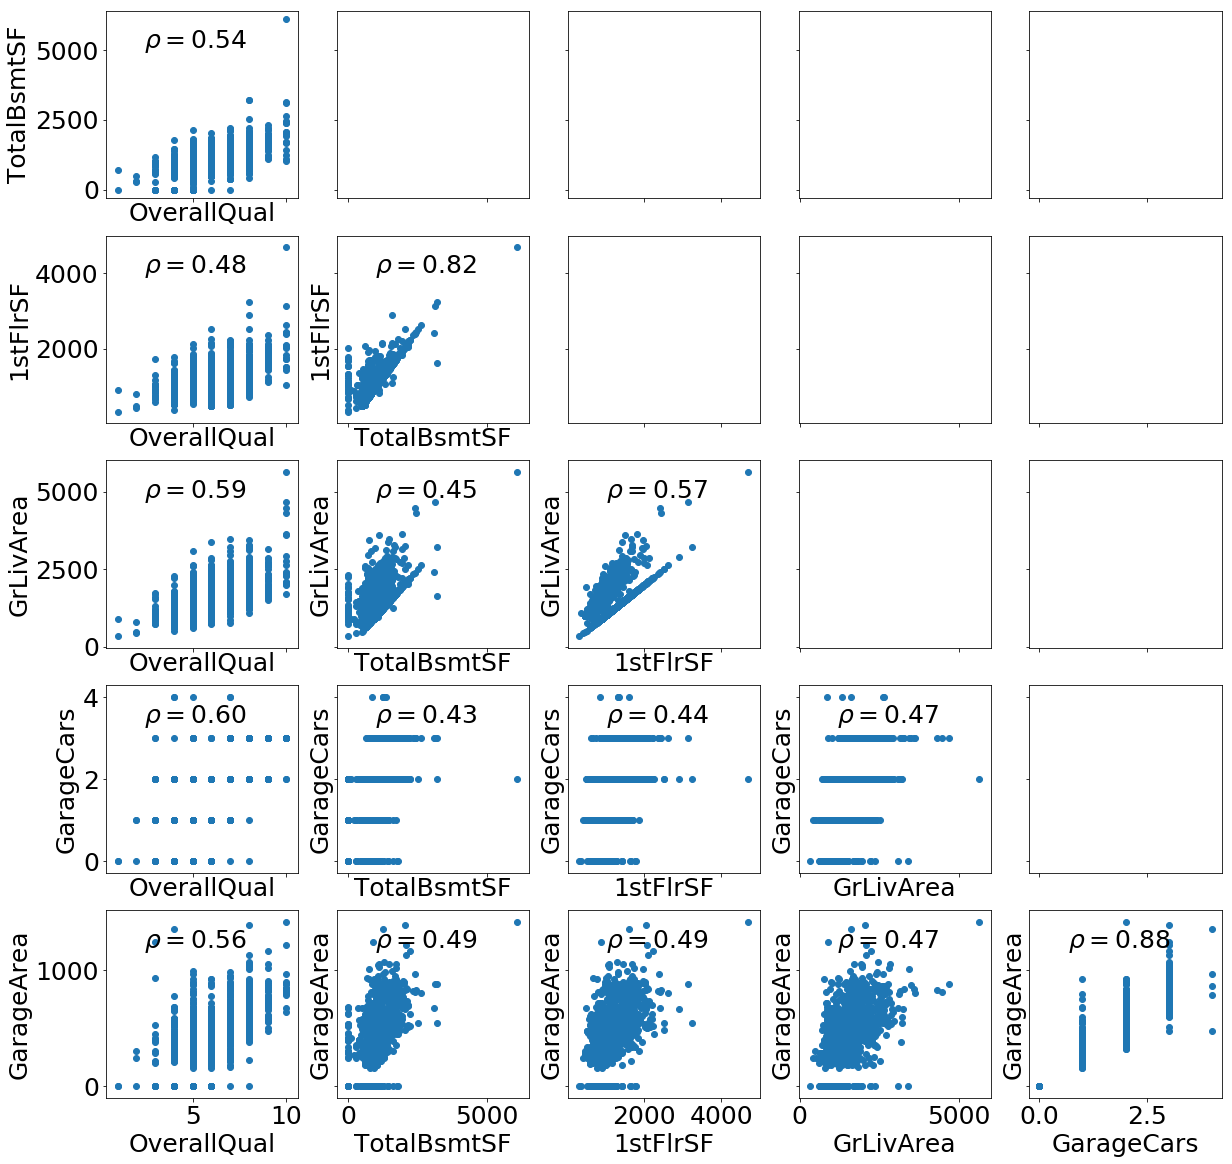

In [14]:
sel_var = num_feat['variable'][num_feat['rho']>0.6]
n=len(sel_var)-1

fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(20, 20), sharex='col', sharey='row')

for i1, var1 in enumerate(sel_var):
    for i2, var2 in enumerate(sel_var):
        if i1>=i2: continue
        row = i2-1
        col = i1
        make_scatter(var1, var2, axs[row, col])
        plt.text(0.2, 0.8, r'$\rho=${:.2f}'.format(pearsonr(train_init[var1], train_init[var2])[0]),
                 transform=axs[row, col].transAxes)

plt.show()

Some of the numerical features are discrete. In the following we investigate more in detail the most powerful discrete features:

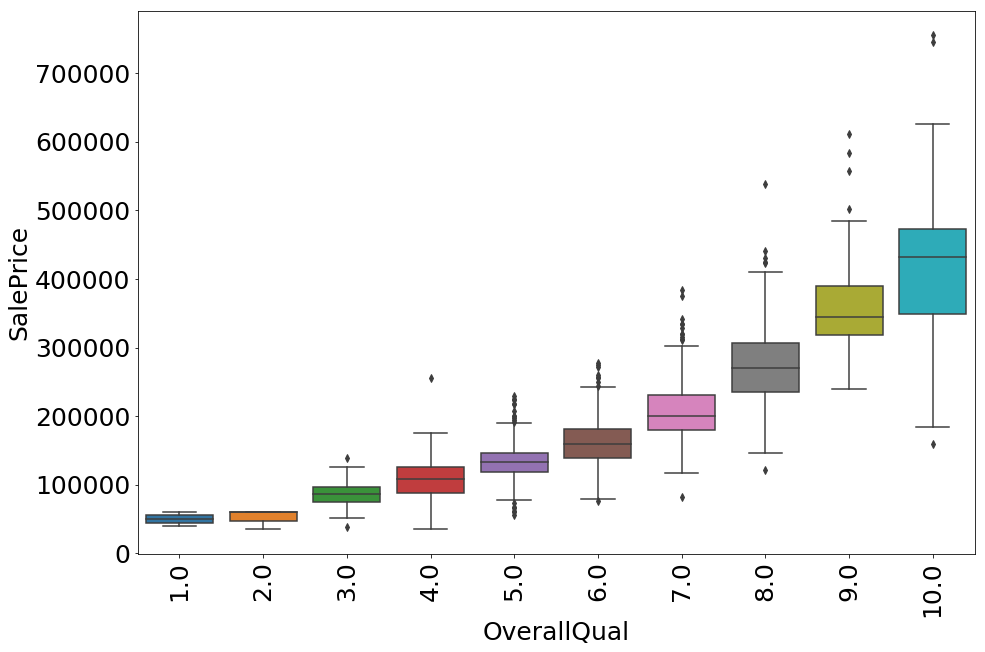

In [15]:
plt.subplots(figsize=(15, 10))

sns.boxplot(x='OverallQual', y="SalePrice", data=train_init)
plt.xticks(rotation = 90)

plt.show()

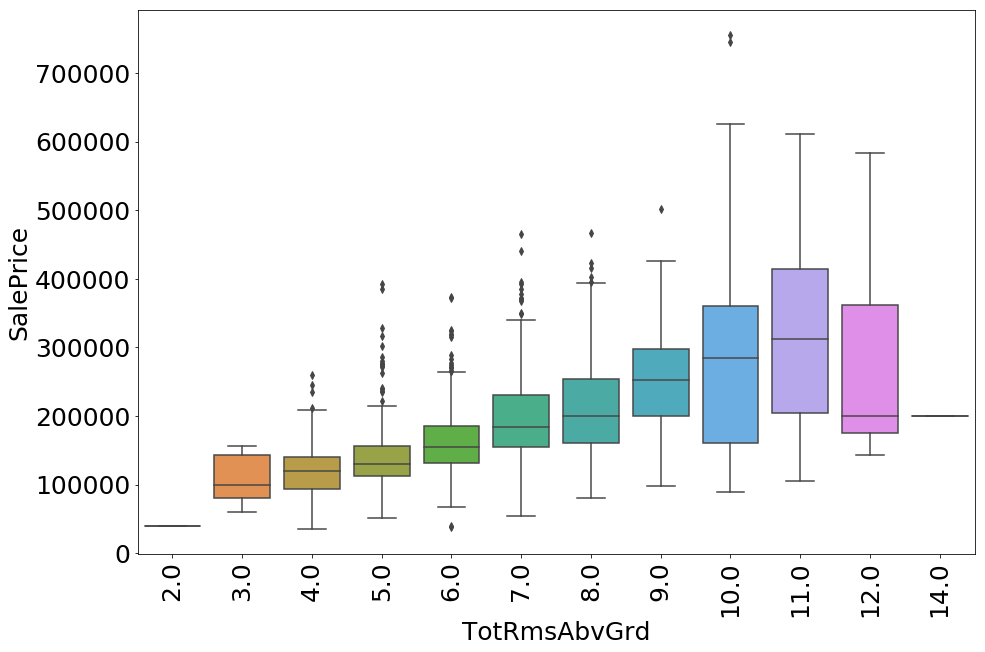

In [16]:
plt.subplots(figsize=(15, 10))

sns.boxplot(x='TotRmsAbvGrd', y="SalePrice", data=train_init)
plt.xticks(rotation = 90)

plt.show()

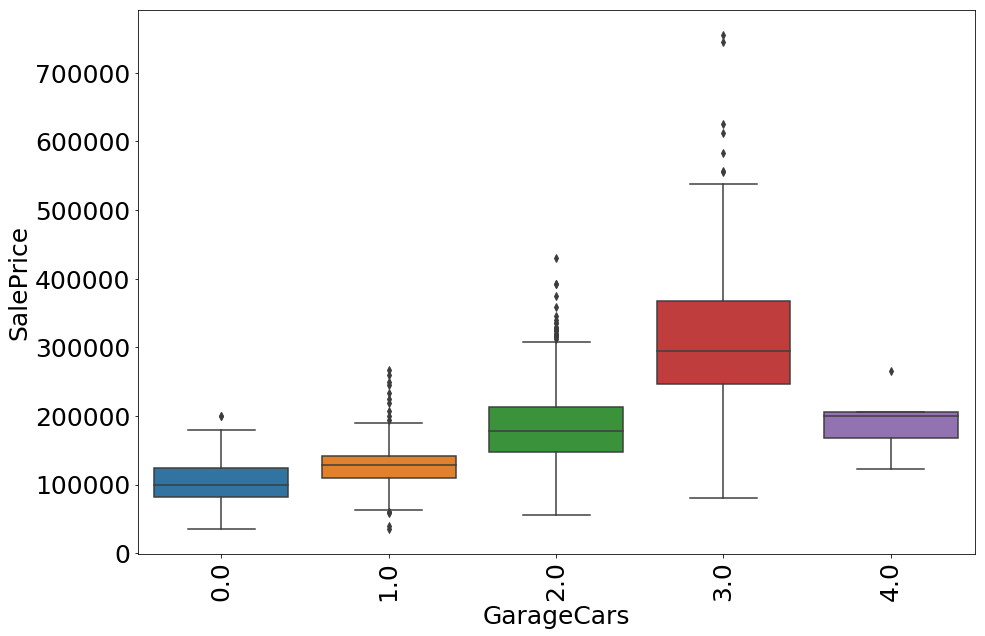

In [17]:
plt.subplots(figsize=(15, 10))

sns.boxplot(x='GarageCars', y="SalePrice", data=train_init)
plt.xticks(rotation = 90)

plt.show()

## 1.2 Categorical Features

In [18]:
categorical_features = train_init.select_dtypes(include=['object']).columns #select discrete features, type str
print('Categorical features (%d):\n %s' %(len(categorical_features), categorical_features))

Categorical features (43):
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


### 1.2.1 Handling Missing Values

Some selected categorical features contain many NaN values:

In [19]:
test_init[categorical_features].isna().sum() #count the missing value for each feature

MSZoning            4
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         16
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinType2       42
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
KitchenQual         1
Functional          2
FireplaceQu       730
GarageType         76
GarageFinish       78
GarageQual         78
GarageCond         78
PavedDrive          0
PoolQC           1456
Fence            1169
MiscFeature      1408
SaleType            1
SaleCondition       0
dtype: int64

In these cases, a NaN value is an indicator of a missing characteristic (e.g. the pool in `PoolQC`). We can therefore set those NaN values to a string None

In [20]:
for var in categorical_features:
    train_init[var].fillna('None', inplace=True)
    test_init[var].fillna('None', inplace=True)

### 1.2.2 Encoding Categorical Features

The values that the categorical features can assume are listed below:

In [21]:
for var in categorical_features:
    print(var)
    print(np.unique(train_init[var]))

MSZoning
['C (all)' 'FV' 'RH' 'RL' 'RM']
Street
['Grvl' 'Pave']
Alley
['Grvl' 'None' 'Pave']
LotShape
['IR1' 'IR2' 'IR3' 'Reg']
LandContour
['Bnk' 'HLS' 'Low' 'Lvl']
Utilities
['AllPub' 'NoSeWa']
LotConfig
['Corner' 'CulDSac' 'FR2' 'FR3' 'Inside']
LandSlope
['Gtl' 'Mod' 'Sev']
Neighborhood
['Blmngtn' 'Blueste' 'BrDale' 'BrkSide' 'ClearCr' 'CollgCr' 'Crawfor'
 'Edwards' 'Gilbert' 'IDOTRR' 'MeadowV' 'Mitchel' 'NAmes' 'NPkVill'
 'NWAmes' 'NoRidge' 'NridgHt' 'OldTown' 'SWISU' 'Sawyer' 'SawyerW'
 'Somerst' 'StoneBr' 'Timber' 'Veenker']
Condition1
['Artery' 'Feedr' 'Norm' 'PosA' 'PosN' 'RRAe' 'RRAn' 'RRNe' 'RRNn']
Condition2
['Artery' 'Feedr' 'Norm' 'PosA' 'PosN' 'RRAe' 'RRAn' 'RRNn']
BldgType
['1Fam' '2fmCon' 'Duplex' 'Twnhs' 'TwnhsE']
HouseStyle
['1.5Fin' '1.5Unf' '1Story' '2.5Fin' '2.5Unf' '2Story' 'SFoyer' 'SLvl']
RoofStyle
['Flat' 'Gable' 'Gambrel' 'Hip' 'Mansard' 'Shed']
RoofMatl
['ClyTile' 'CompShg' 'Membran' 'Metal' 'Roll' 'Tar&Grv' 'WdShake'
 'WdShngl']
Exterior1st
['AsbShng' 'AsphS

To encode categorical features, we distinguish between ordinal features and not. For ordinal features, we use the `OrdinalEncoder`, for the rest we use the `LabelEncoder`. Both provided with sklearn

In [22]:
# ORDINAL FEATURES
#as some categories might appear in the test data but not in the train data,
#we need to apply the encoder to the train+test data. We concatenate them
all_data = pd.concat([train_init, test_init], sort=False).reset_index(drop=True)

#we define the encoders
lab_encoder = LabelEncoder()
ord_encoder = OrdinalEncoder(categories=[['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
ord_feature =  ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
            'HeatingQC', 'KitchenQual', 'FireplaceQu', 'PoolQC',
            'GarageQual', 'GarageCond']

#We encode the categorical features
for var in categorical_features:
    if var in ord_feature: all_data[var] = ord_encoder.fit_transform(all_data[[var]])
    else: all_data[var] = lab_encoder.fit_transform(all_data[[var]].values.ravel())

In [23]:
#We assign the encoded features to the train and test datasets
for var in categorical_features:
    train_init[var] = all_data[var][:len(train_init)].values
    test_init[var]  = all_data[var][len(train_init):].values

Let us check that the categorical features have been correctly encoded:

In [24]:
for var in categorical_features:
    print(var)
    print(np.unique(test_init[var]))

MSZoning
[0 1 2 3 4 5]
Street
[0 1]
Alley
[0 1 2]
LotShape
[0 1 2 3]
LandContour
[0 1 2 3]
Utilities
[0 2]
LotConfig
[0 1 2 3 4]
LandSlope
[0 1 2]
Neighborhood
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Condition1
[0 1 2 3 4 5 6 7 8]
Condition2
[0 1 2 3 4]
BldgType
[0 1 2 3 4]
HouseStyle
[0 1 2 4 5 6 7]
RoofStyle
[0 1 2 3 4 5]
RoofMatl
[1 5 6 7]
Exterior1st
[ 0  1  2  3  4  5  6  8  9 10 12 13 14 15]
Exterior2nd
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16]
MasVnrType
[0 1 2 3]
ExterQual
[2. 3. 4. 5.]
ExterCond
[1. 2. 3. 4. 5.]
Foundation
[0 1 2 3 4 5]
BsmtQual
[0. 2. 3. 4. 5.]
BsmtCond
[0. 1. 2. 3. 4.]
BsmtExposure
[0 1 2 3 4]
BsmtFinType1
[0 1 2 3 4 5 6]
BsmtFinType2
[0 1 2 3 4 5 6]
Heating
[1 2 3 5]
HeatingQC
[1. 2. 3. 4. 5.]
CentralAir
[0 1]
Electrical
[0 1 2 5]
KitchenQual
[0. 2. 3. 4. 5.]
Functional
[0 1 2 3 4 5 6 7]
FireplaceQu
[0. 1. 2. 3. 4. 5.]
GarageType
[0 1 2 3 4 5 6]
GarageFinish
[0 1 2 3]
GarageQual
[0. 1. 2. 3. 4.]
GarageCond
[0. 1

# 2. Symmetrizing Skewed Data

Let us concatenate all the features in one single list (`SalePrice` is excluded from this list):

In [25]:
all_features = np.concatenate((numerical_features, categorical_features), axis=0)
all_features

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'E

Some features are highly asymmetric. We parametrize the asymmetry through the skewness:

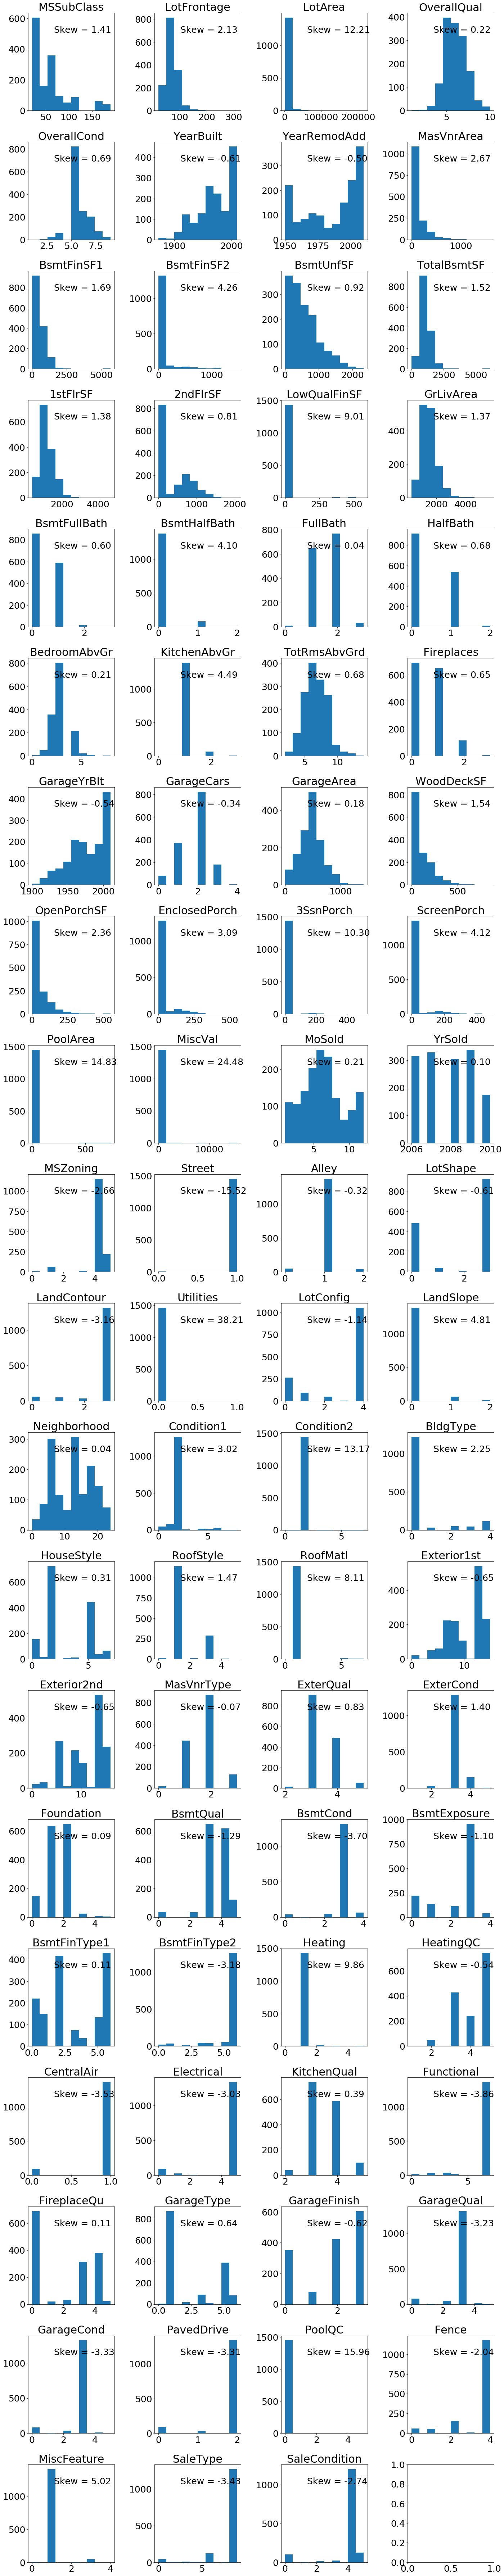

In [26]:
nrows, ncols = 20, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 100))

skew = []
for ivar, var in enumerate(all_features):
    row = int(ivar/ncols)
    col = ivar%ncols
    axs[row, col].hist(train_init[var])
    axs[row, col].set_title(var)
    skew.append(train_init[var].skew())
    axs[row,col].text(0.3, 0.8, 'Skew = {:.2f}'.format(skew[-1]), transform=axs[row, col].transAxes)
plt.tight_layout()
plt.show()

In [27]:
skewness = pd.DataFrame({
    'feature': all_features,
    'skewness': skew
})
skewness.sort_values(by=['skewness'], ascending=False)

feature   skewness
41   Utilities  38.209946
33     MiscVal  24.476794
74      PoolQC  15.958567
32    PoolArea  14.828374
46  Condition2  13.171844
..         ...        ...
77    SaleType  -3.426661
64  CentralAir  -3.530386
58    BsmtCond  -3.701033
67  Functional  -3.857714
37      Street -15.518770

[79 rows x 2 columns]

Some features are *highly skewed* (skewness>0.7). We symmetrize these features with a log1p function:

In [28]:
skewed_features = skewness['feature'][np.abs(skewness['skewness'])>0.7]

for feat in skewed_features:
    train_init[feat] = np.log1p(train_init[feat])
    test_init[feat]  = np.log1p(test_init[feat])
        
train_init['SalePrice'] = np.log1p(train_init['SalePrice'])

/home/francesco/.local/lib/python3.5/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


We check that the distributions have been symmetrized, and that the test and train dataset are similar

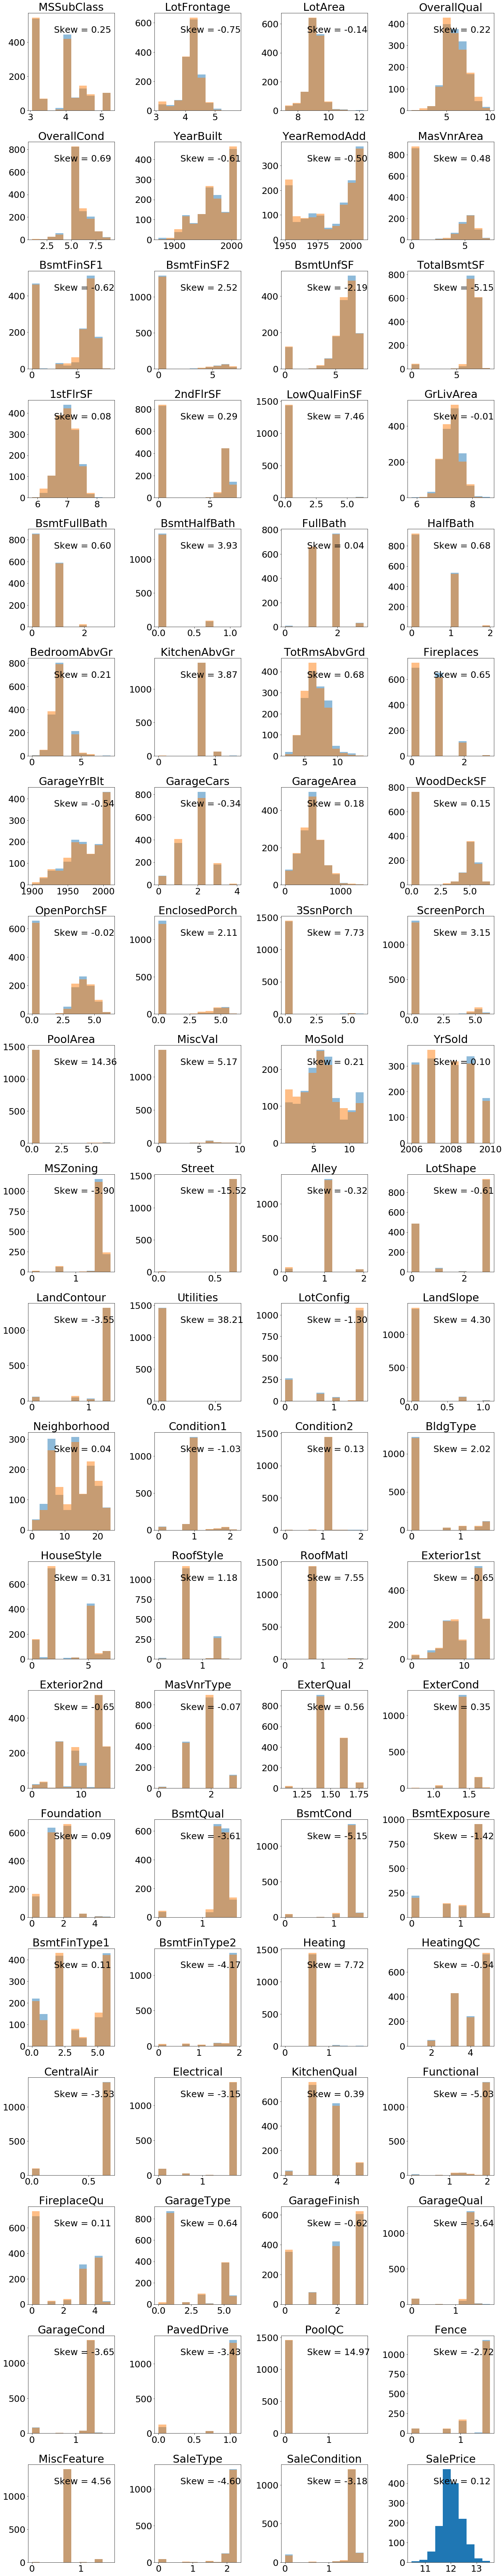

In [29]:
nrows, ncols = 20, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 100))

skew = []
for ivar, var in enumerate(all_features):
    row = int(ivar/ncols)
    col = ivar%ncols
    h, bins, _ = axs[row, col].hist(train_init[var], alpha=0.5)
    axs[row, col].hist(test_init[var], bins=bins, alpha=0.5)
    axs[row, col].set_title(var)
    skew.append(train_init[var].skew())
    axs[row,col].text(0.3, 0.8, 'Skew = {:.2f}'.format(skew[-1]), transform=axs[row, col].transAxes)

axs[19, 3].hist(train_init['SalePrice'])
axs[19, 3].text(0.3, 0.8, 'Skew = {:.2f}'.format(train_init['SalePrice'].skew()), transform=axs[19, 3].transAxes)
axs[19, 3].set_title('SalePrice')

plt.tight_layout()
plt.show()

# 3 Feature Selection

We empirically found that the following features are optimal for the model training in section 4:

In [30]:
remove_features = ['MasVnrArea', 'Utilities', 'ScreenPorch', 'BsmtFinSF2', 'EnclosedPorch',
                    'MoSold', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'LandContour', 'PavedDrive',
                    '2ndFlrSF', 'BsmtFinType1', 'BsmtFinType2']

sel_features = [feat for feat in all_features if feat not in remove_features]
print('Selected features (%d):\n%s' %(len(sel_features), sel_features))

Selected features (65):
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'PoolArea', 'YrSold', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


Let us plot the ranges of these features

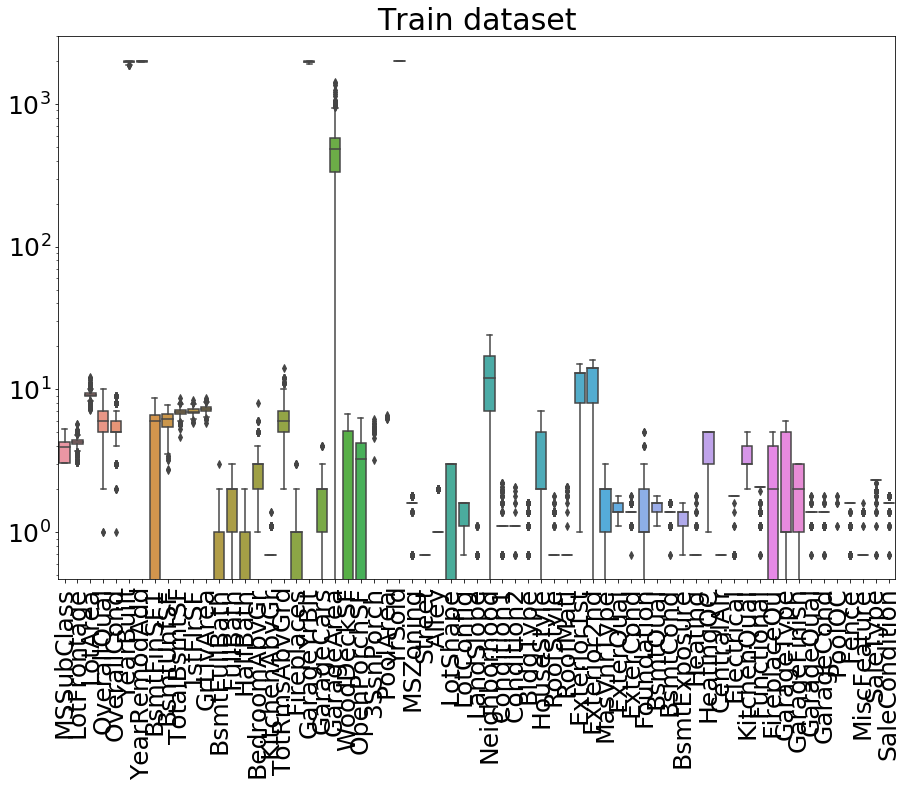

In [31]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.boxplot(data=train_init[sel_features])
plt.yscale('log')
plt.xticks(rotation = 90)
plt.title('Train dataset')
plt.show()

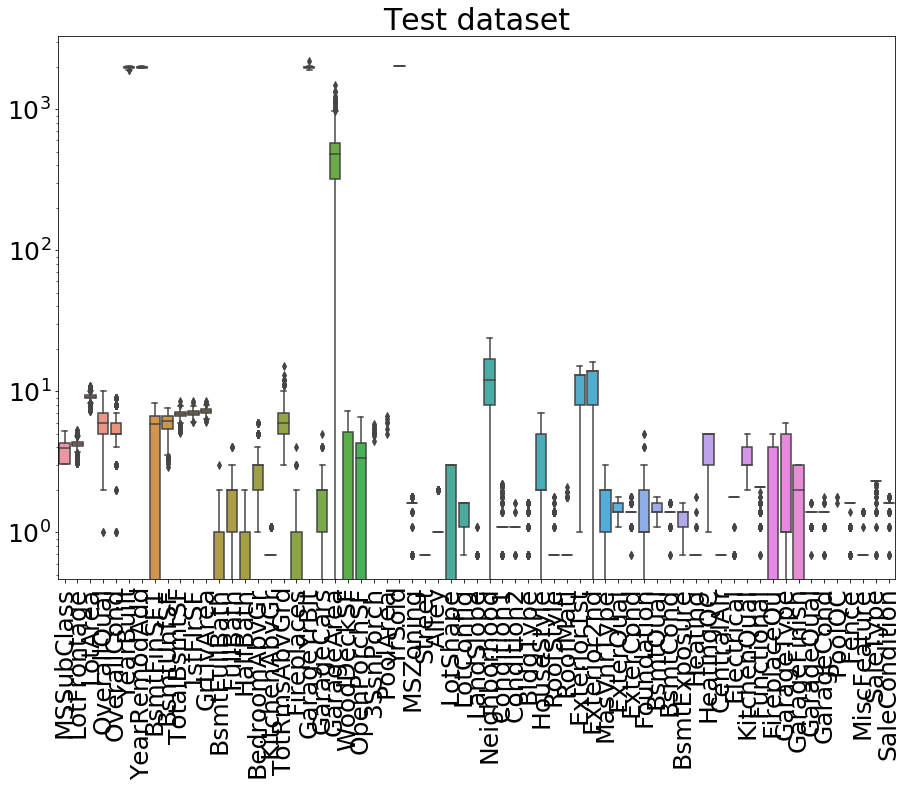

In [32]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.boxplot(data=test_init[sel_features])
plt.yscale('log')
plt.xticks(rotation = 90)
plt.title('Test dataset')
plt.show()

The selected features spans different ranges. Therefore, during the model selection we need to scale them. Furthermore, we also notice the presence of significant outliers. We will consider it during the training of the models

# 4 Model Selection

## 4.1 Train/Test Samples Definition

First, we define the training dataset/target and the test dataset:

In [33]:
X_train, y_train = train_init[sel_features], train_init['SalePrice']
X_test = test_init[sel_features]

## 4.2 Useful Functions

Then, we define some useful functions for the training of the model:

In [34]:
def make_grid_search(model, param_grid):
    """
    Make a grid search to optimize the model parameter
    Args:
        model (object): the machine learning model to train
        param_grid (dict): a dictionary of the parameter values to optimize with the search grid
    return:
        grid (GridSearchCV): the optimized GridSearchCV object
    """
    grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=False, verbose=1)
    grid.fit(X_train, y_train)
    
    return grid
    
def fit_pipeline(scaler, model):
    """
    Create a pipeline (data scaling + model fitting in this case)
    Args:
        scaler (object): the scaler to be applied to the data
        model (object): the machine learning model to train
    return:
        pipe (Pipeline): the pipeline object after fit
        score (float): the performance score of the model (RMS error)
    """
    pipe = Pipeline([('scaler', scaler), ('model', model)])
    score = -cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error').mean()
    pipe.fit(X_train, y_train)
    
    return pipe, score

def fill_list(name, model, score):
    """
    Auxiliary function to fill the relevant lists to be used for model comparison
    Args:
        name (str): the name of the model
        model (object): the machine learning model to train
        score (float): the performance score of the model (RMS error)
    """
    model_names.append(name)
    models.append(model)
    scores.append(score)

We also define some functions to make the relevant plots:

In [35]:
def make_prediction_plot(pipe, title):
    """
    Visualize the prediction of the model on the training sample
    Arg:
        pipe (Pipeline): the pipeline of processes for the model
        title (str): the name of the model, to be used as the plot title
    """
    idxs = np.argsort(y_train)
    y_pred = pipe.predict(X_train)[idxs]

    fig, axs = plt.subplots(2, 1, figsize=(15,12), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    x = np.arange(len(y_train))
    axs[0].plot(x, y_train[idxs], label='Target (sorted)')
    axs[0].plot(x, y_pred, ls='', marker='.', label='Prediction')
    axs[0].set_ylabel('log1p_SalePrice')
    axs[0].set_title(title)
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y_pred/y_train[idxs])
    axs[1].grid()
    axs[1].set_xlabel('Sorted target index')
    axs[1].set_ylabel('pred/true ratio')
    plt.show()
    
def make_feat_importance_plot(importances):
    """
    Visualize the feature importance
    Arg:
        importances (list): weights of the features
    """
    fig, ax = plt.subplots(figsize=(20,10))
    feat_importances = pd.Series(importances, index=sel_features)
    feat_importances.plot.bar(ax=ax)
    plt.title('Feature Importance')
    plt.grid()
    plt.show()

## 4.3 Model Training

We define three lists of useful variables to store:

In [36]:
scores, model_names, models = [], [], []

The possible metrics to evaluate the model performance are shown below:

In [37]:
metrics.SCORERS.keys()

dict_keys(['normalized_mutual_info_score', 'neg_root_mean_squared_error', 'f1_micro', 'roc_auc', 'f1_weighted', 'roc_auc_ovr_weighted', 'jaccard_samples', 'r2', 'max_error', 'balanced_accuracy', 'precision_macro', 'recall_weighted', 'precision_weighted', 'average_precision', 'jaccard_weighted', 'neg_mean_squared_log_error', 'jaccard_macro', 'f1_macro', 'homogeneity_score', 'roc_auc_ovr', 'roc_auc_ovo_weighted', 'neg_log_loss', 'recall_macro', 'jaccard_micro', 'jaccard', 'adjusted_mutual_info_score', 'neg_mean_poisson_deviance', 'precision', 'precision_micro', 'accuracy', 'recall_samples', 'roc_auc_ovo', 'neg_mean_gamma_deviance', 'neg_mean_squared_error', 'v_measure_score', 'f1_samples', 'neg_brier_score', 'fowlkes_mallows_score', 'recall_micro', 'adjusted_rand_score', 'recall', 'precision_samples', 'f1', 'completeness_score', 'mutual_info_score', 'neg_mean_absolute_error', 'explained_variance', 'neg_median_absolute_error'])

In this project we use the `neg_root_mean_squared_error`

### 4.3.1 Linear Regression

Linear regression score: 0.13615637850853832


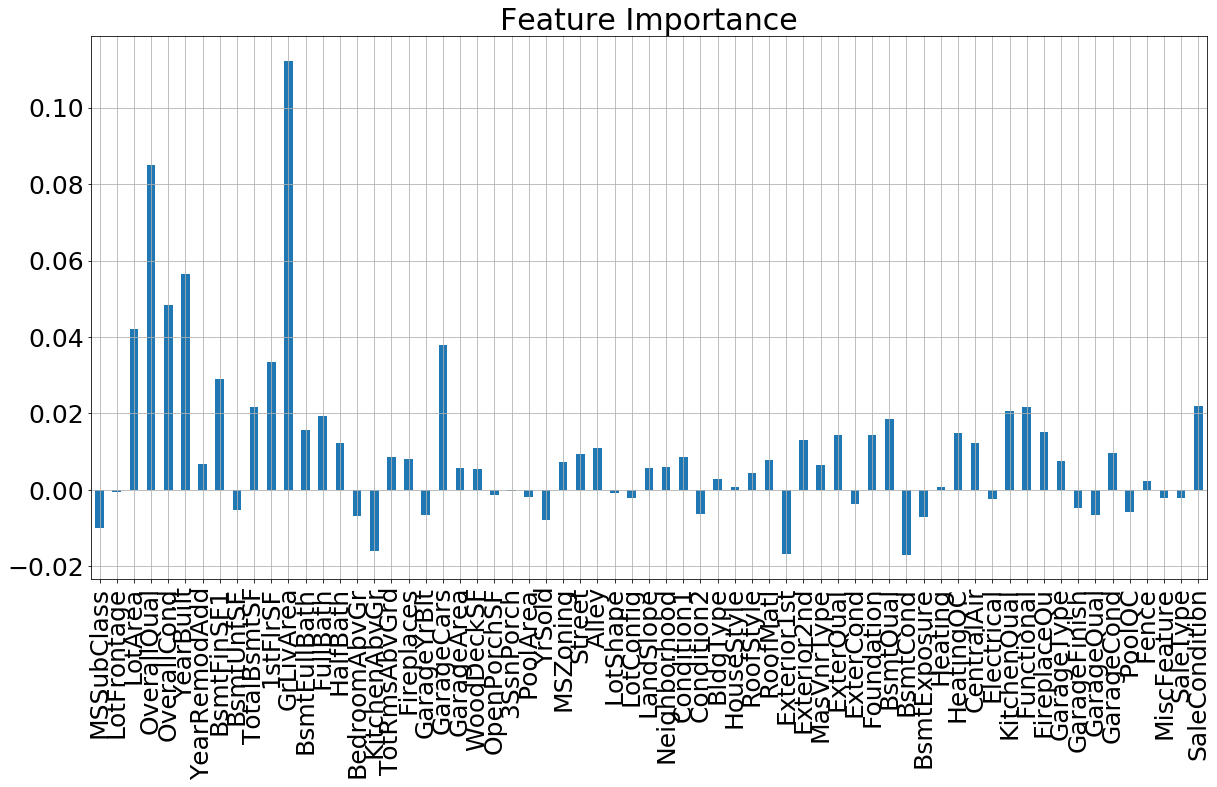

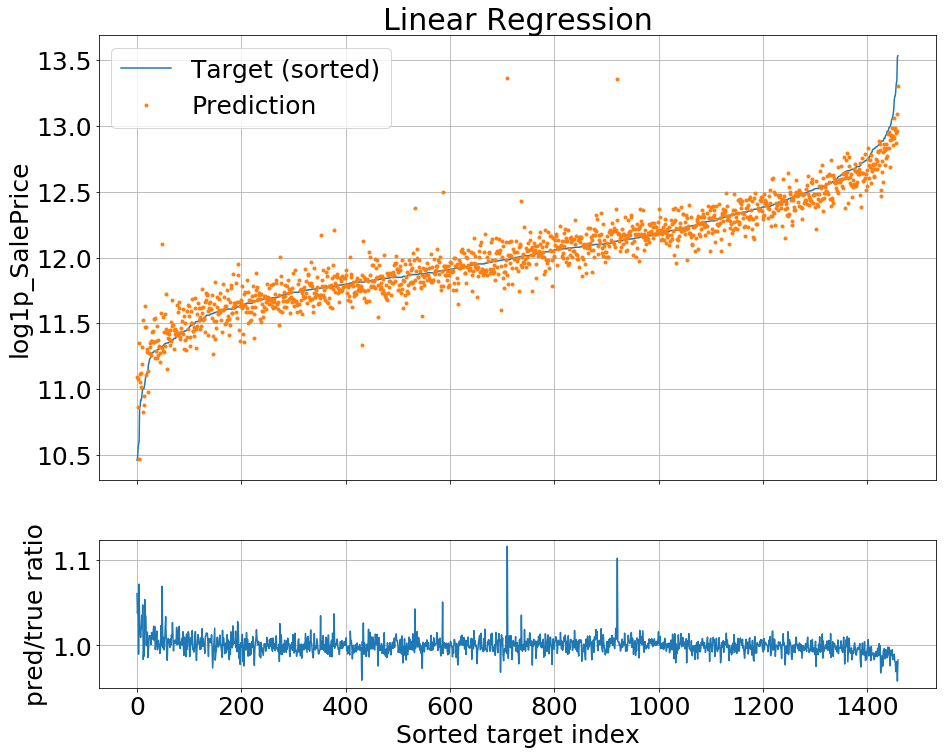

In [38]:
#scale & fit
pipe_lr, score_lr = fit_pipeline(StandardScaler(), LinearRegression(normalize=False))
print('Linear regression score:', score_lr)

#plots
make_feat_importance_plot(importances = pipe_lr['model'].coef_)
make_prediction_plot(pipe_lr, 'Linear Regression')

#fill list
fill_list('LR', pipe_lr, score_lr)

### 4.3.2 Ridge Regression

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.6s finished


Ridge regression score: 0.13525995047368597


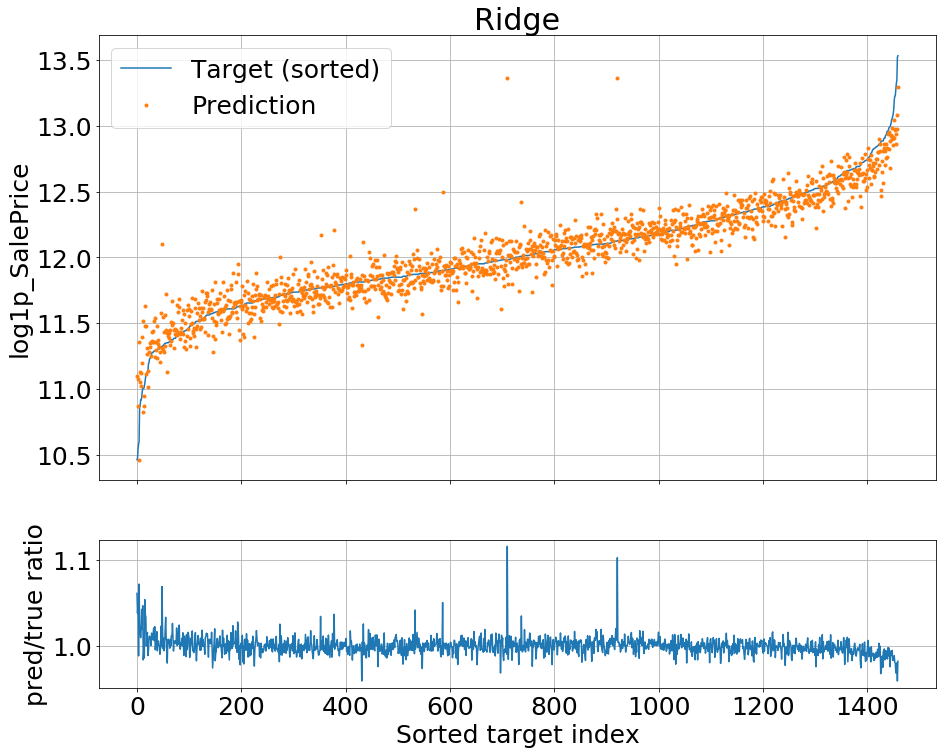

In [39]:
#GridSearchCV to optimize model parameters
param_grid = [{
    'alpha': np.logspace(-5, 1, 30),
}]
grid_ridge = make_grid_search(Ridge(), param_grid)

#scale & fit
pipe_ridge, score_ridge = fit_pipeline(RobustScaler(), grid_ridge.best_estimator_)
print('Ridge regression score:', score_ridge)

#plot
make_prediction_plot(pipe_ridge, 'Ridge')

#fill list
fill_list('Ridge', pipe_ridge, score_ridge)

### 4.3.3 LASSO Regression

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.3s finished


LASSO regression score: 0.13521685382137752


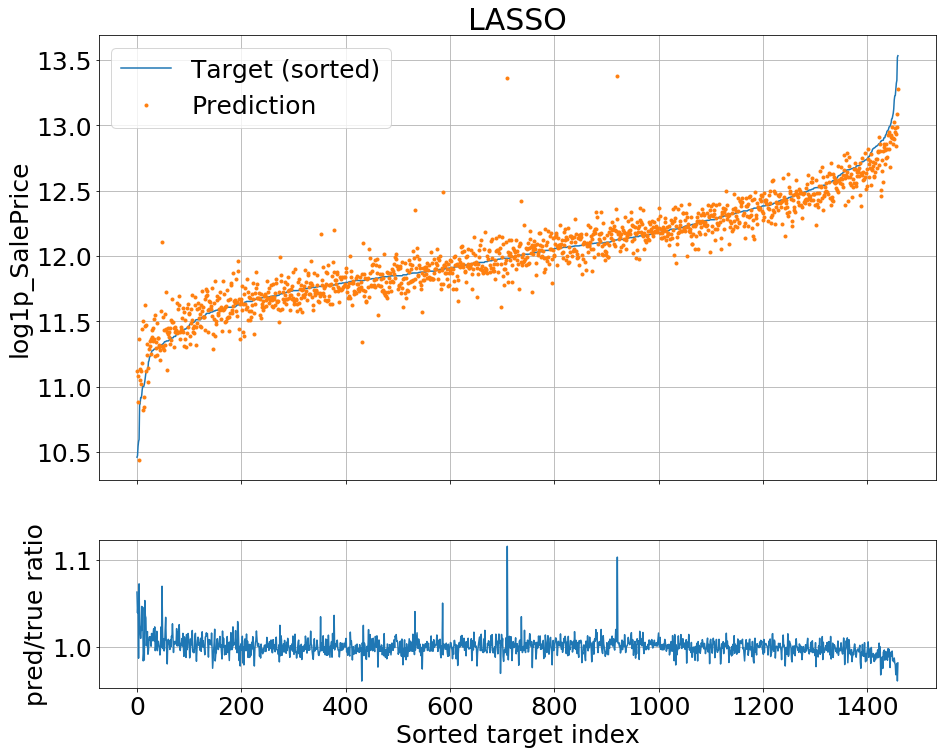

In [40]:
#GridSearchCV to optimize model parameters
param_lasso = [{
    'alpha': np.logspace(-5, 1, 30),
}]
grid_lasso = make_grid_search(Lasso(), param_grid)

#scale & fit
pipe_lasso, score_lasso = fit_pipeline(RobustScaler(), grid_lasso.best_estimator_)
print('LASSO regression score:', score_lasso)

#plot
make_prediction_plot(pipe_lasso, 'LASSO')

#fill list
fill_list('LASSO', pipe_lasso, score_lasso)

### 4.3.4 k-Nearest Neighbor Regression

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.7s finished


kNN regression score: 0.17331776271772287


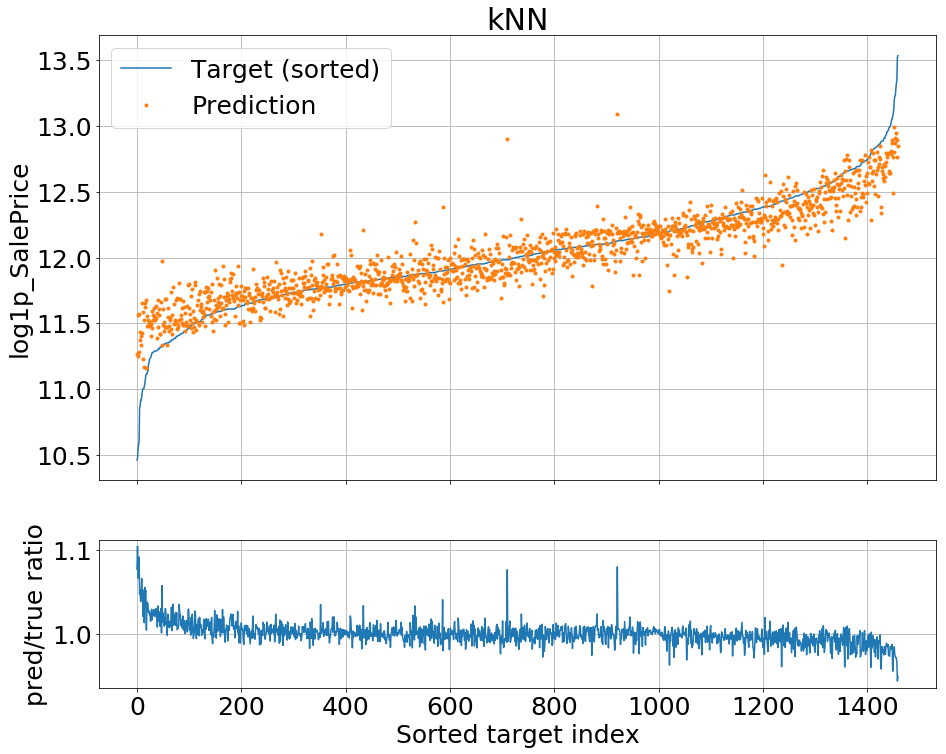

In [41]:
#GridSearchCV to optimize model parameters
param_grid = [{
    'n_neighbors': range(1, 31),
}]
grid_kNN = make_grid_search(KNeighborsRegressor(), param_grid)

#scale & fit
pipe_kNN, score_kNN = fit_pipeline(RobustScaler(), grid_kNN.best_estimator_)
print('kNN regression score:', score_kNN)

#plot
make_prediction_plot(pipe_kNN, 'kNN')

#fill list
fill_list('kNN', pipe_kNN, score_kNN)

### 4.3.5 Gradient Boosting Regressor

Gradient Boosting Regressor score: 0.12674822363522448


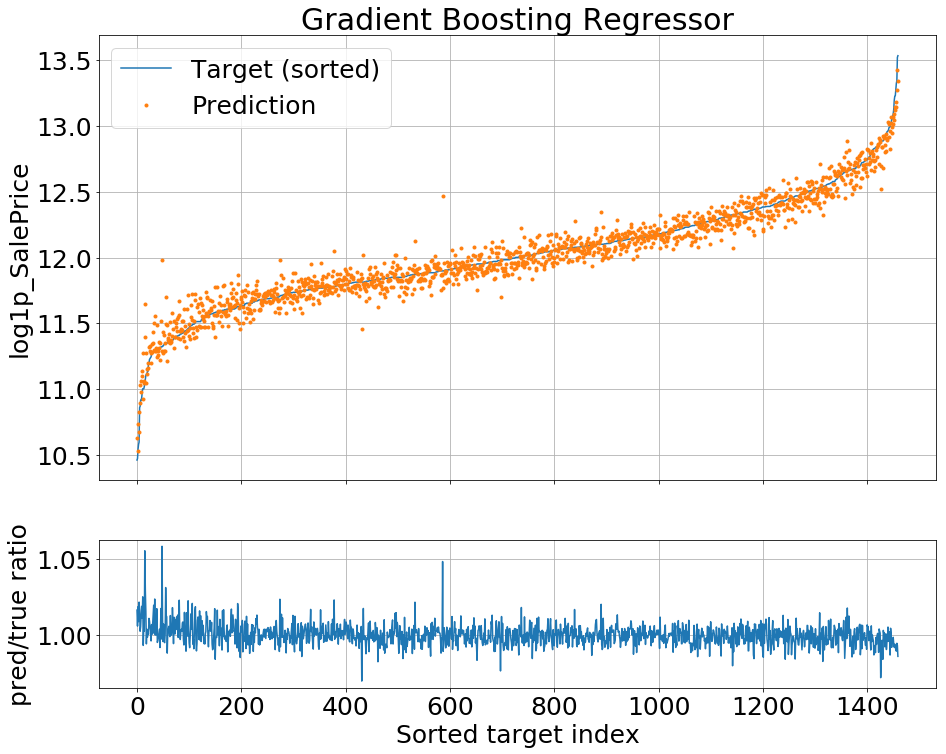

In [42]:
#scale & fit
pipe_GBR, score_GBR = fit_pipeline(StandardScaler() , GradientBoostingRegressor() )
print('Gradient Boosting Regressor score:', score_GBR)

#plot
make_prediction_plot(pipe_GBR, 'Gradient Boosting Regressor')

#fill list
fill_list('GBR', pipe_GBR, score_GBR)

### 4.3.6 Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.7s finished


Random Forest regression score: 0.14420699548845128


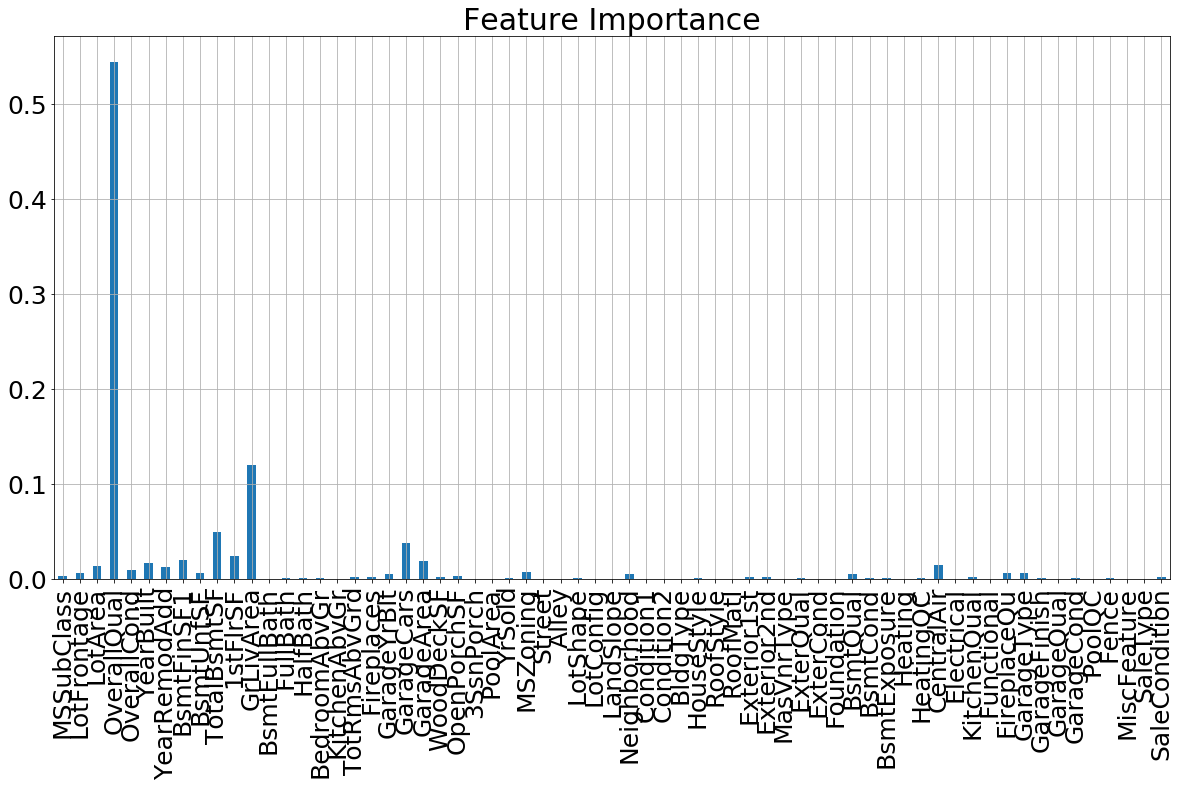

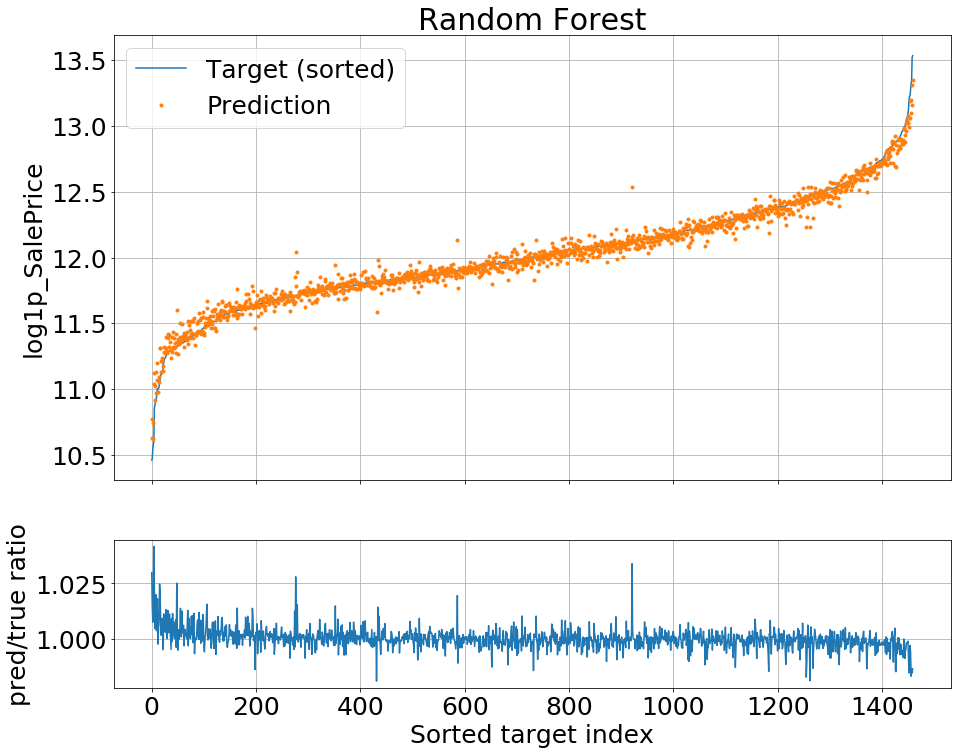

In [43]:
#GridSearchCV to optimize model parameters
param_grid = [{
    'n_estimators': range(1, 21),
}]
grid_RF = make_grid_search(RandomForestRegressor(), param_grid)

#scale & fit
pipe_RF, score_RF = fit_pipeline(RobustScaler(), grid_RF.best_estimator_)
print('Random Forest regression score:', score_RF)

#plots
make_feat_importance_plot(importances = grid_RF.best_estimator_.feature_importances_)
make_prediction_plot(pipe_RF, 'Random Forest')

#fill list
fill_list('RF', pipe_RF, score_RF)

### 4.3.7 Support Vector Machine

Support Vector Machine regression score: 0.13985766030311378


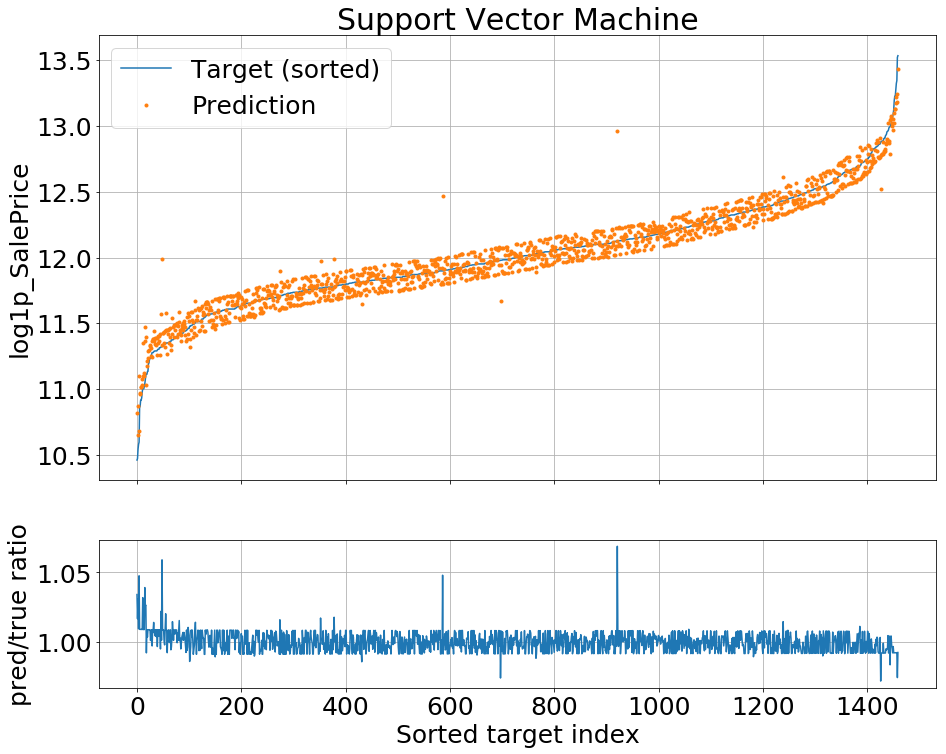

In [44]:
#scale & fit
pipe_SVM, score_SVM = fit_pipeline(RobustScaler(), SVR())
print('Support Vector Machine regression score:', score_SVM)

#plot
make_prediction_plot(pipe_SVM, 'Support Vector Machine')

#fill list
fill_list('SVM', pipe_SVM, score_SVM)

## 4.4 Model Prediction

Let us visualize the model scores:

In [45]:
model_results = pd.DataFrame({
    'name': model_names,
    'score': scores,
    'model': models
})
model_results[['name', 'score']] #.sort_values(by=['score'], ascending=True)

name     score
0     LR  0.136156
1  Ridge  0.135260
2  LASSO  0.135217
3    kNN  0.173318
4    GBR  0.126748
5     RF  0.144207
6    SVM  0.139858

Now we average the predictions of the best models. In doing so, we take into account that the models have different performance, and we attribute higher weights to the best models. In practice, we make a weighted average of the best models' predictions. As such, we define the following functions:

In [46]:
def make_weights(RMSs):
    """
    Make the weights of the weighted average prediction
    Args:
        RMSs (list of floats): list of model scores
    Return:
        w/w_sum (list of floats): the list of weights for the selected models
    """
    w = 1./(RMSs*RMSs)
    w_sum = np.sum(w)
    return w/w_sum

def make_prediction(RMSs, models, X):
    """
    Calculate the weighted average predictions
    Args:
        RMSs (list of floats): list of model scores
        model (list of objects): list of machine learning models
        X (pd.DataFrame): dataset for prediction
    Return:
        y_hat (pd.DataFrame): weighted average prediction
    """
    w = make_weights(RMSs)
    
    y_hat = np.zeros(len(X))
    for i in range(len(w)):
        y_hat += w[i] * models[i].predict(X)
    
    return y_hat

Let us evaluate the performance of the weighted average predictions using a subset of of machine learning models trained in section 4.3. For this, we predict from X_train

In [47]:
y_hat_train = make_prediction(model_results['score'].iloc[[0,2,4,5]].values,
                              model_results['model'].iloc[[0,2,4,5]].values,
                              X_train)
print('score (RMS error):', np.sqrt(mean_squared_error(y_train, y_hat_train)))

score (RMS error): 0.09219416016319311


Finally, the weighted average prediction is (notice that we use X_test now):

In [48]:
y_hat = make_prediction(model_results['score'].iloc[[0,2,4,5]].values,
                        model_results['model'].iloc[[0,2,4,5]].values,
                        X_test)

In [49]:
submission = pd.DataFrame(
    {
        'Id': test_init['Id'],
        'SalePrice': np.exp(y_hat)-1
    }
)
submission.to_csv('submission.csv',index=False)

The actual score on the test sample is 0.12652. We are in the **top 17%**!!! 